In [ ]:
!pip install -q transformers datasets scikit-learn torch accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.1 MB/s eta 0:00:00


In [ ]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [ ]:

# Core imports
import json
import torch
import numpy as np
from torch.utils.data import Dataset
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from transformers import (
    AutoConfig,
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
    DataCollatorWithPadding,
)

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data
def load_json(path):
    with open(path, 'r', encoding='utf-8') as f:
        return json.load(f)

train_data = load_json("/content/drive/MyDrive/model_finetuning/train.json")
val_data   = load_json("/content/drive/MyDrive/model_finetuning/val.json")
test_data  = load_json("/content/drive/MyDrive/model_finetuning/test.json")
print(f"Train/Val/Test sizes: {len(train_data)}/{len(val_data)}/{len(test_data)}")


Train/Val/Test sizes: 2838/355/355


In [ ]:
# Dataset class
class SentimentDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        enc = self.tokenizer(
            item["text"],
            truncation=True,
            max_length=self.max_length,
            padding="max_length",
            return_tensors="pt"
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels":         torch.tensor(item["label"], dtype=torch.long)
        }

In [ ]:
# Model and tokenizer setup
MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

config = AutoConfig.from_pretrained(
    MODEL,
    num_labels=3,
    hidden_dropout_prob=0.4, # Increased dropout
    attention_probs_dropout_prob=0.4 # Increased dropout
)
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL, config=config)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
# Datasets
train_ds = SentimentDataset(train_data, tokenizer)
val_ds   = SentimentDataset(val_data, tokenizer)
test_ds  = SentimentDataset(test_data, tokenizer)


In [ ]:
# Custom trainer with class weights
class WeightedTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        if self.train_dataset is not None and self.model is not None:
            train_labels = [ex["label"] for ex in self.train_dataset.data]
            classes = np.unique(train_labels)
            cw = compute_class_weight("balanced", classes=classes, y=train_labels)
            self.class_weights = torch.tensor(cw, dtype=torch.float).to(self.model.device)
        else:
            self.class_weights = None

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is None:
            raise ValueError("Class weights not initialized. Ensure train_dataset and model are provided.")

        labels = labels.to(logits.device)  # Ensure labels are on the same device
        loss_fn = torch.nn.CrossEntropyLoss(weight=self.class_weights)
        loss = loss_fn(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [ ]:
# Metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=-1)
    labels = p.label_ids
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }

# Collator
data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
# Training arguments
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/model_finetuning/cardiff_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    save_total_limit=2,
    report_to=[],  # Disable W&B
    fp16=True,
    push_to_hub=False,
)


In [ ]:
# Initialize trainer
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)




<ipython-input-10-e4cddff866ce>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


In [ ]:

print("🚀 Fine-tuning CardiffNLP model…")
trainer.train()

🚀 Fine-tuning CardiffNLP model…


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,0.863700,0.706031,0.647887,0.599282
2,0.717600,0.556141,0.723944,0.710204
3,0.658500,0.440104,0.808451,0.808707
4,0.588700,0.518395,0.794366,0.792061
5,0.568600,0.568434,0.743662,0.733661


TrainOutput(global_step=890, training_loss=0.6794260003593531, metrics={'train_runtime': 527.9583, 'train_samples_per_second': 53.754, 'train_steps_per_second': 3.371, 'total_flos': 3733579397560320.0, 'train_loss': 0.6794260003593531, 'epoch': 5.0})

In [ ]:
# Evaluate on test set
print("\n✅ Evaluating on test set...")
metrics = trainer.evaluate(test_ds)
print("✅ Test metrics:", metrics)



✅ Evaluating on test set...


✅ Test metrics: {'eval_loss': 0.3993683159351349, 'eval_accuracy': 0.8422535211267606, 'eval_f1_macro': 0.844322357347926, 'eval_runtime': 2.7529, 'eval_samples_per_second': 128.955, 'eval_steps_per_second': 4.359, 'epoch': 5.0}



Classification Report:
               precision    recall  f1-score   support

         neg       0.76      0.92      0.83       105
         neu       0.90      0.70      0.79       141
         pos       0.88      0.94      0.91       109

    accuracy                           0.84       355
   macro avg       0.85      0.86      0.84       355
weighted avg       0.85      0.84      0.84       355



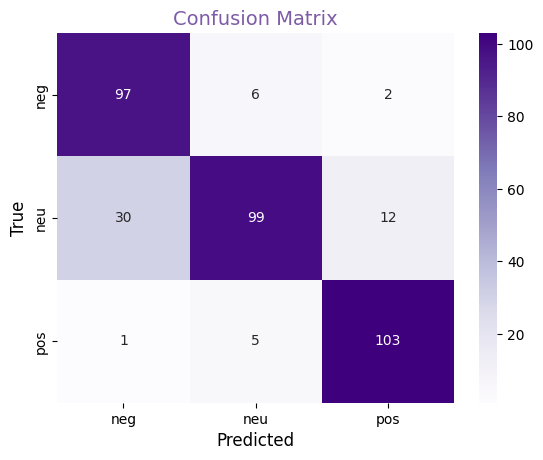

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
pred_out = trainer.predict(test_ds)
preds = np.argmax(pred_out.predictions, axis=-1)
labels = pred_out.label_ids

cm = confusion_matrix(labels, preds)
print("\nClassification Report:\n", classification_report(labels, preds, target_names=["neg", "neu", "pos"]))

# Plot confusion matrix with lilac purple color palette
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["neg", "neu", "pos"],
            yticklabels=["neg", "neu", "pos"],
            cmap="Purples")  # Lilac/purple theme
plt.title("Confusion Matrix", fontsize=14, color="#7D5BA6")  # Optional: lilac title color
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)
plt.show()




---



In [ ]:
# Save model
out_dir = "/content/drive/MyDrive/model_finetuning/cardiff_finetuned"
model.save_pretrained(out_dir)
tokenizer.save_pretrained(out_dir)
model.config.save_pretrained(out_dir)
print(f"\n✅ Model & tokenizer saved to: {out_dir}")



---



In [ ]:
import pandas as pd

# Load training log history
log_history = trainer.state.log_history
df_logs = pd.DataFrame(log_history)

# Filter out steps with loss/metrics
df_train = df_logs[df_logs["loss"].notna()]
df_eval  = df_logs[df_logs["eval_loss"].notna()]


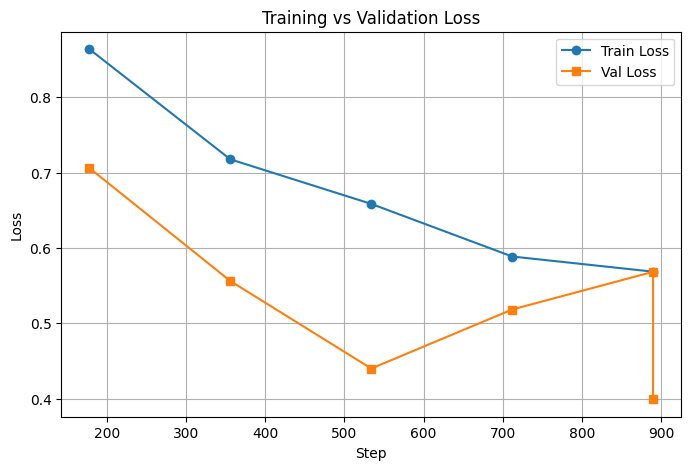

In [ ]:
#📈 2. Plot Training vs Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(df_train["step"], df_train["loss"], label="Train Loss", marker='o')
plt.plot(df_eval["step"], df_eval["eval_loss"], label="Val Loss", marker='s')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


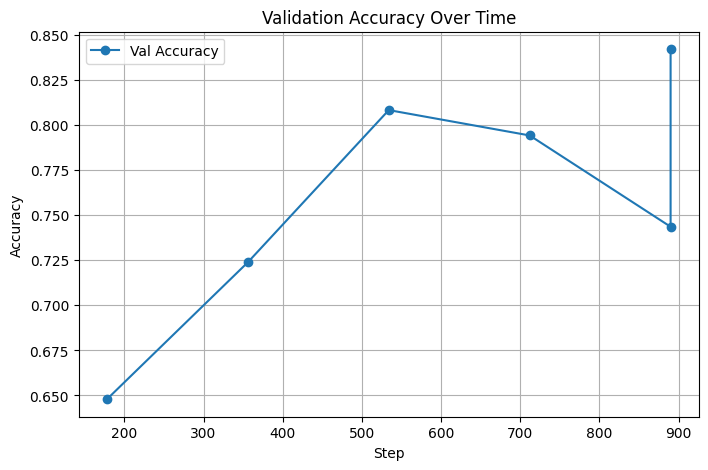

In [ ]:
#📊 3. Plot Training vs Validation Accuracy
plt.figure(figsize=(8, 5))
plt.plot(df_eval["step"], df_eval["eval_accuracy"], label="Val Accuracy", marker='o')
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.show()


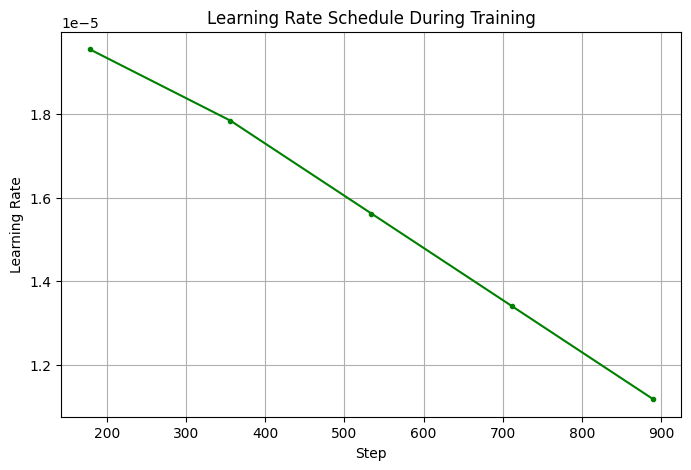

In [ ]:
#📉 4. Plot Learning Rate Schedule
plt.figure(figsize=(8, 5))
plt.plot(df_train["step"], df_train["learning_rate"], label="Learning Rate", color="green", marker='.')
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule During Training")
plt.grid(True)
plt.show()


In [ ]:
#🔁 5. Before vs After Fine-tuning Comparison
# Load base model (before fine-tuning)
from transformers import AutoModelForSequenceClassification

base_model = AutoModelForSequenceClassification.from_pretrained(MODEL, config=config).to(model.device)

# Create new trainer for base model
base_trainer = Trainer(
    model=base_model,
    args=training_args,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("🔍 Evaluating base model (before fine-tuning)...")
base_metrics = base_trainer.evaluate()
print("Before fine-tuning:", base_metrics)

print("🔍 Evaluating fine-tuned model (after fine-tuning)...")
fine_metrics = trainer.evaluate(test_ds)
print("After fine-tuning:", fine_metrics)

# Tabulate results
import pandas as pd

comparison = pd.DataFrame([base_metrics, fine_metrics], index=["Before", "After"])
print("\n📊 Before vs After Fine-tuning Metrics")
display(comparison[["eval_loss", "eval_accuracy", "eval_f1_macro"]])


<ipython-input-22-2978130ef0fd>:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  base_trainer = Trainer(


🔍 Evaluating base model (before fine-tuning)...


Before fine-tuning: {'eval_loss': 0.5672903060913086, 'eval_model_preparation_time': 0.0026, 'eval_accuracy': 0.7943661971830986, 'eval_f1_macro': 0.7977730000915745, 'eval_runtime': 2.6042, 'eval_samples_per_second': 136.317, 'eval_steps_per_second': 4.608}
🔍 Evaluating fine-tuned model (after fine-tuning)...


After fine-tuning: {'eval_loss': 0.3993683159351349, 'eval_accuracy': 0.8422535211267606, 'eval_f1_macro': 0.844322357347926, 'eval_runtime': 2.5249, 'eval_samples_per_second': 140.598, 'eval_steps_per_second': 4.753, 'epoch': 5.0}

📊 Before vs After Fine-tuning Metrics


,eval_loss,eval_accuracy,eval_f1_macro
Before,0.567290,0.794366,0.797773
After,0.399368,0.842254,0.844322
